In [1]:
indir = "/data2/mito_lineage/output/annotation_clones/data/cd34norm/MTblacklist/DE_large"
n_donors = 4
n_top_genes = 5

cdf_thresh = 0.3

In [2]:
outdir <- paste0(indir, "/", "cdf_thresh__", (100*cdf_thresh))
dir.create(outdir)

Warning message in dir.create(outdir):
“'/data2/mito_lineage/output/annotation_clones/data/cd34norm/MTblacklist/DE_large/cdf_thresh__30' already exists”


In [3]:
library(Seurat)
library(Signac)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)
library("ComplexHeatmap")
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)

Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.9.4
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




Load

## Import seurat object

In [4]:
se <- readRDS(file.path(indir, "se.clonesfilt.rds"))
large.clones <- read.csv(file.path(indir, "large_clones.csv"))
large.clones <- large.clones %>% filter(cdf.norm<cdf_thresh)
large.clones
se <- subset(se, subset= name %in% factor(large.clones$name))

X,donor,lineage,norm.total,total,name,cdf.norm,cdf,index
<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>
1,0,0,0.18226037,415,0_0,0.09113018,415,1
2,0,52,0.15614398,276,0_52,0.16920217,691,2
3,0,2,0.13733539,281,0_2,0.23786987,972,3
8,1,0,0.13459662,254,1_0,0.06729831,254,1
9,1,1,0.10784947,200,1_1,0.12122304,454,2
10,1,2,0.10021547,196,1_2,0.17133078,650,3
11,1,3,0.08930252,180,1_3,0.21598203,830,4
12,1,5,0.08537228,172,1_5,0.25866817,1002,5
19,2,0,0.23917201,377,2_0,0.11958600,377,1


In [5]:
Idents(se) <- "name"

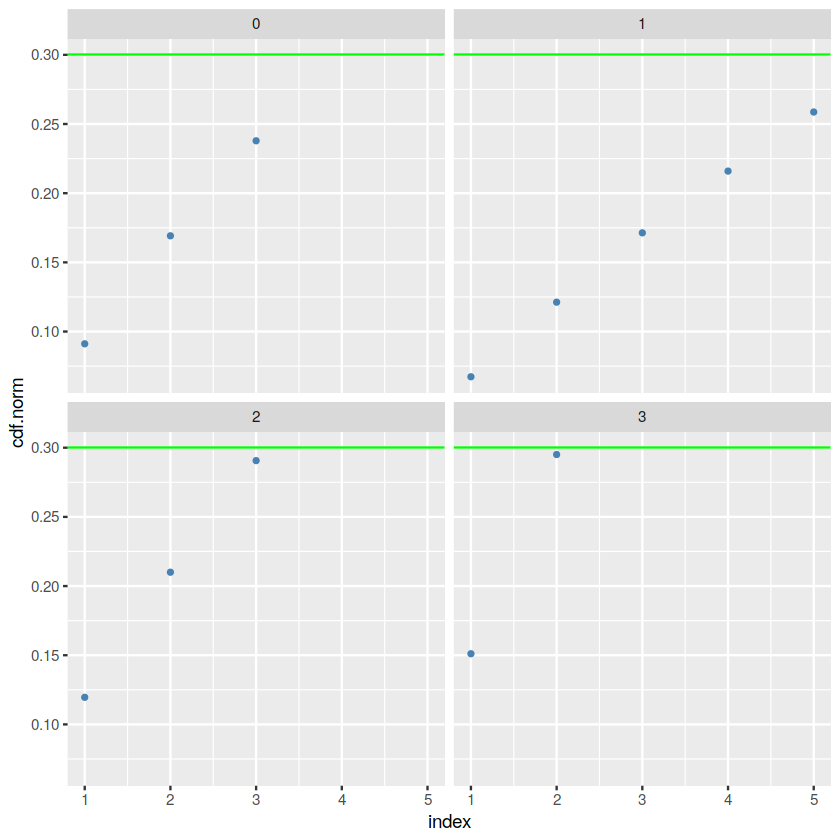

In [6]:
p <- ggplot(data = large.clones, aes(index, cdf.norm)) +
  geom_point(color = "steelblue", size = 1) +
  facet_wrap(~ donor) 

p <- p + geom_hline(yintercept=cdf_thresh, color='green') 
p

In [ ]:
## Get motif names

# DefaultAssay(se) <- "chromvar"
# chrom.var.names <- GetAssayData(se)
# DefaultAssay(se) <- "ATAC"
# motifs <- Motifs(se)
# #Motifs(se)@motif.names

# head(chrom.var.names)
# row.names(chrom.var.names) <- sapply(row.names(chrom.var.names), function(x) {Motifs(se)@motif.names[[x]]})
# head(chrom.var.names)




In [8]:
GetAssayData(se)

,Control_AAACGAAAGCGATACG-1,Control_AAACGAAGTAACGGTG-1,Control_AAACGAAGTAAGTCTC-1,Control_AAACGAATCGCGCTGA-1,Control_AAACTCGAGATTACGA-1,Control_AAACTCGCAAGACTTC-1,Control_AAACTCGCACAAGGGT-1,Control_AAACTCGCACCTCGTT-1,Control_AAACTCGCATCGCCTT-1,Control_AAACTGCAGCATGTGG-1,⋯,Flt3l_TTTGGTTCACAGGAAC-1,Flt3l_TTTGGTTCATGGGAAC-1,Flt3l_TTTGGTTGTATCGCGC-1,Flt3l_TTTGGTTTCAGTACAC-1,Flt3l_TTTGTGTAGAGGTCCA-1,Flt3l_TTTGTGTCAAGGGTAC-1,Flt3l_TTTGTGTCACGCCGAT-1,Flt3l_TTTGTGTCAGCAACCC-1,Flt3l_TTTGTGTGTATTCTGG-1,Flt3l_TTTGTGTGTTTGACCA-1
FOXF2,1.13471963,0.11195265,0.42312204,-1.25931965,-1.8169784,-1.14115964,-0.2577676,-0.30024137,2.291114915,-0.43706326,⋯,-1.50077858,0.77682738,-1.69219190,1.58216707,0.0264187652,-0.86790947,0.319707964,0.62073443,-0.05227834,0.56722744
FOXD1,1.00950412,-1.11794029,-0.71564985,-0.34346026,-1.7006714,0.11160780,2.3136194,-0.50308463,2.609149797,0.15681238,⋯,0.09745578,0.79360677,0.34995287,-1.60694589,0.7015798813,-1.48977037,2.120432893,0.40719712,0.68321372,0.34357852
IRF2,2.52636431,-0.31428148,1.44221476,0.75201664,-1.4083571,1.93877195,-1.8153567,2.07481285,1.925689457,1.02369592,⋯,0.44873335,0.02532074,0.63820160,-1.38216516,0.5960102564,-0.80125088,-0.145058493,0.50193099,1.32184774,-0.51881646
MZF1(var.2),0.94740752,-0.28005361,0.30625290,-0.28128957,-0.5692435,0.38384388,-0.5271641,-0.10788434,1.723070596,0.27859541,⋯,-0.59854805,-0.48791559,-0.75602128,1.62601428,-1.0993806139,-0.13075601,-0.297686346,-1.64774299,0.19355946,0.20585925
MAX::MYC,-0.90147852,0.77501314,1.70961983,1.35959855,-0.9576184,1.49344477,-1.9971575,-0.69016582,1.585166536,0.12617982,⋯,-2.21043429,-0.38753852,-0.66042203,-1.59842741,-2.5901752905,0.16450212,-0.571172928,0.39149943,-0.57138880,-0.01378068
PPARG,0.41628054,-0.84483275,-0.91516152,-1.14665400,-0.9802267,-0.18553143,0.6740232,-1.23817195,-1.900681538,-0.53492032,⋯,0.41419579,-1.08507803,0.16741472,0.18298078,0.7692873597,0.20749227,-0.855066321,-1.16065946,0.18240956,1.46347337
PAX6,1.54032086,-1.15349704,-0.54471729,-0.40338683,-0.7735738,0.32643251,-0.5436767,0.44841351,0.893522886,0.05545624,⋯,-0.94108066,0.34491877,0.76833897,-0.41455290,0.1790377745,0.03222025,0.005849327,1.93479601,0.52706085,-0.92787404
PBX1,0.20811761,0.59566398,0.49638416,-0.12633229,-0.3850520,0.89868601,-0.8523533,-0.37415934,-0.278534050,1.56537904,⋯,1.01059441,-1.34979704,2.20310092,-1.68503634,-0.4211786892,-1.62262776,-0.272696867,-1.42389812,0.89447550,-1.63458091
RORA,1.48119361,-1.89531098,0.06949987,-0.41302103,0.3336531,-0.31736463,-0.1035260,0.35070574,0.478400981,-0.72089245,⋯,-0.82717981,1.02745540,0.27418939,-1.26462434,0.1949648972,2.23898876,0.147045488,-0.16863722,0.33087808,0.97054875
RORA(var.2),-1.06548602,0.78450023,-0.31501249,1.24124452,-0.3629574,-0.34506119,-0.7997563,0.97730013,0.561369920,1.56217377,⋯,-2.12271146,-0.87409805,0.22639781,0.83477846,-0.1251271160,-0.84705591,-0.603707981,0.19055620,1.05827869,0.01470558


## TF DE

## Summarize results

In [9]:
all.names.sig <- c()
DefaultAssay(se) <- "chromvarnames"
for (d in 0:(n_donors-1)){
    print('donor')
    print(d)
    curr.indir <- file.path(indir, paste0("donor", d, "_TF"))
    curr.outdir <- file.path(outdir, paste0("donor", d, "_TF"))
    dir.create(curr.outdir)
    donor.large.clones <- large.clones %>% filter(donor==d)
    clones.filt.ids <- donor.large.clones$lineage
    se.filt <- subset(se, subset = (donor==d) & (lineage %in% donor.large.clones$lineage))
    pairs = combn(clones.filt.ids,2)
    names.sig <- c()

    for (i in 1:dim(pairs)[2]){
        print(pairs[,i])
            print(paste("clones", i))
            a = pairs[1,i]
            b = pairs[2,i]
            curr.tf.da <- read.csv(file.path(curr.indir, 
                                             paste0("clones_",a,"__", b,".DE.TF.csv"))) %>% 
                          arrange(p_val)
            row.names(curr.tf.da) <- sapply(curr.tf.da$X, function(m) {motifs@motif.names[[m]]})
            #curr.tf.da
            names.sig <- c(names.sig, head(row.names(curr.tf.da), n_top_genes))
            all.names.sig <- c(all.names.sig, head(row.names(curr.tf.da), n_top_genes))
            }
    names.sig <- unique(names.sig)
    names.sig

    #feat <- FeaturePlot(se.filt,  features=names.sig)

    vln <- VlnPlot(se.filt,  features=names.sig)

    dot <- DotPlot(se.filt, features = names.sig) + RotatedAxis()

    # split by a vector
    pdf((file.path(curr.outdir, "heatmap.top.pdf")), width=8,height=8)
    
    heat <- ComplexHeatmap::Heatmap(GetAssayData(se.filt)[names.sig,], 
            name = paste0("donor",d),
            column_split = se.filt[[]]["lineage"],
            show_column_names = FALSE, use_raster=TRUE
           )
    ComplexHeatmap::draw(heat)
    dev.off()
    
    ggsave(plot=dot, 
           file=file.path(curr.outdir, ("dot.top.png")))
    ggsave(plot=vln, 
           file=file.path(curr.outdir, ("violin.top.png")))
    }
all.names.sig <- unique(all.names.sig)

[1] "donor"
[1] 0


Warning message in dir.create(curr.outdir):
“'/data2/mito_lineage/output/annotation_clones/data/cd34norm/MTblacklist/DE_large/cdf_thresh__30/donor0_TF' already exists”


[1]  0 52
[1] "clones 1"
[1] 0 2
[1] "clones 2"
[1] 52  2
[1] "clones 3"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "donor"
[1] 1


Warning message in dir.create(curr.outdir):
“'/data2/mito_lineage/output/annotation_clones/data/cd34norm/MTblacklist/DE_large/cdf_thresh__30/donor1_TF' already exists”


[1] 0 1
[1] "clones 1"
[1] 0 2
[1] "clones 2"
[1] 0 3
[1] "clones 3"
[1] 0 5
[1] "clones 4"
[1] 1 2
[1] "clones 5"
[1] 1 3
[1] "clones 6"
[1] 1 5
[1] "clones 7"
[1] 2 3
[1] "clones 8"
[1] 2 5
[1] "clones 9"
[1] 3 5
[1] "clones 10"


The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "donor"
[1] 2


Warning message in dir.create(curr.outdir):
“'/data2/mito_lineage/output/annotation_clones/data/cd34norm/MTblacklist/DE_large/cdf_thresh__30/donor2_TF' already exists”


[1] 0 1
[1] "clones 1"
[1] 0 2
[1] "clones 2"
[1] 1 2
[1] "clones 3"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "donor"
[1] 3


Warning message in dir.create(curr.outdir):
“'/data2/mito_lineage/output/annotation_clones/data/cd34norm/MTblacklist/DE_large/cdf_thresh__30/donor3_TF' already exists”


[1]  0 36
[1] "clones 1"


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



## Heatmap for all donors

In [10]:
pdf((file.path(outdir, "heatmap.allDonors.top.pdf")), width=8,height=8)
heat <- ComplexHeatmap::Heatmap(GetAssayData(se)[names.sig,], 
        top_annotation = HeatmapAnnotation(donor=as.character(se$donor)),
        show_column_names = FALSE, 
        column_split = se[["name"]],
       )

ComplexHeatmap::draw(heat)
dev.off()

png 
  2

In [11]:
pdf((file.path(outdir, "heatmap.allDonors.anno.top.pdf")), width=8,height=8)
heat <- ComplexHeatmap::Heatmap(GetAssayData(se)[all.names.sig,], 
        top_annotation = HeatmapAnnotation(donor=as.character(se$donor), clone=as.character(se$lineage), 
                                           depth=anno_barplot(log10(se$peak_region_fragments))),
        show_column_names = FALSE
       )

ComplexHeatmap::draw(heat)
dev.off()

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

In [12]:
pdf((file.path(outdir, "heatmap.allDonors.split.top.pdf")), width=8,height=8)
heat <- ComplexHeatmap::Heatmap(GetAssayData(se)[all.names.sig,], 
        top_annotation = HeatmapAnnotation(donor=as.character(se$donor)),
        show_column_names = FALSE, 
        column_split = se[["name"]],
       )

ComplexHeatmap::draw(heat)
#dev.off()

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

